In [1]:
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import time
from tqdm.notebook import tqdm

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


In [2]:
class VGG19(nn.Module):
    def __init__(self,in_dim,num_classes):
        super().__init__()
        self.features = nn.Sequential(
             nn.Conv2d(in_dim,64,kernel_size=3,padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(inplace=True),
             nn.Conv2d(64,64,kernel_size=3,padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2,stride=2),
 
             nn.Conv2d(64,128,kernel_size=3,padding=1),
             nn.BatchNorm2d(128),
             nn.ReLU(inplace=True),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
             nn.BatchNorm2d(128),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2,stride=2),
 
             nn.Conv2d(128, 256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.BatchNorm2d(256),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2,stride=2),
            
             nn.Conv2d(256, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2,stride=2),
            
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.BatchNorm2d(512),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2,stride=2)
         )
 
        self.classifier = nn.Sequential(
             nn.Linear(512*7*7,4096),
             nn.ReLU(),
             nn.Dropout(0.5),
 
             nn.Linear(4096,4096),
             nn.ReLU(),
             nn.Dropout(0.5),
            
             nn.Linear(4096,num_classes)
         )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [3]:
train_tf = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968,0.48215841,0.44653091],
                                       [0.24703223,0.24348513,0.26158784])]
)
test_tf = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968,0.48215841,0.44653091],
                                       [0.24703223,0.24348513,0.26158784])]
)

train_dataset = datasets.ImageFolder('./processed_data/train', transform=train_tf)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder('./processed_data/test', transform=test_tf)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

net = VGG19(3,10)
net = torch.nn.DataParallel(net)
print("Available GPUs: ", torch.cuda.device_count())
net.to(device)

Available GPUs:  2


DataParallel(
  (module): VGG19(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding

In [4]:
learning_rate = 1e-3
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate,momentum=0.9)
net.train()

start_time = time.time()
epoch_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        progress_bar.set_postfix(loss=running_loss/(i+1), accuracy=100. * correct / total)

    epoch_acc = 100 * correct / total
    epoch_accuracies.append(epoch_acc)

print("Training completed: --- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Training completed: --- 17408.349511384964 seconds ---


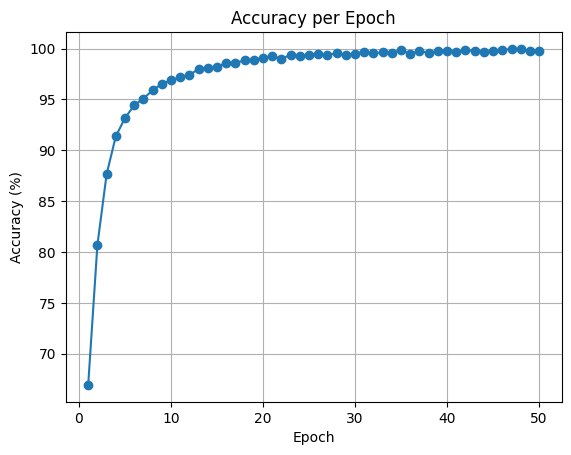

In [5]:
import matplotlib.pyplot as plt

# After the training loop
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [6]:
# Assuming 'model' is your model instance
torch.save(net, 'vgg19.pkl')

# To load the model later
# model = torch.load('model.pkl')

In [7]:
from sklearn.metrics import classification_report, accuracy_score
import torch

# Set the model to evaluation mode
net.eval()

# Initialize variables to keep track of predictions and actual labels
all_predictions = []
all_labels = []

# No gradient is needed for evaluation
with torch.no_grad():
    progress_bar = tqdm(test_loader, total=len(test_loader))
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get output/logits
        outputs = net(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Optionally calculate more detailed performance metrics
print(f"Accuracy on test set: {accuracy * 100:.4f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))


  0%|          | 0/233 [00:00<?, ?it/s]

Accuracy on test set: 97.4680%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4650
           1       0.95      0.98      0.97      2775

    accuracy                           0.97      7425
   macro avg       0.97      0.98      0.97      7425
weighted avg       0.98      0.97      0.97      7425



In [8]:
torch.cuda.empty_cache()